In [ ]:

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer

model=Cylinder_Yaxis_1Layer(sigma=5.e7)
mesh=model.mesh
Draw(mesh)


In [ ]:
import math
import sys
sys.path.append('C:\EMSolution\EMSolPy3\python\include')
from MatrixSolver import MatrixSolver as solver 

jomega=True
f=0.1
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=False
feorder=3

Mu=model.Mu
field=UNIF(0,1,0,0)
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

mu=4.e-7*math.pi
normal = specialcf.normal(mesh.dim)

fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega) 
if Dirichlet==False:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
fesTOmega=fesT*fesOmega    
(T,omega),(W,psi) = fesTOmega.TnT()
a= BilinearForm(fesTOmega)
a +=Mu*(grad(omega)*grad(psi))*dx(air_region)
a +=Mu*((T+grad(omega))*(W+grad(psi)))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()

gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega=gfTOmega.components
if Dirichlet==False:
    b=Bfield(field)
    f = LinearForm(fesTOmega)
    f += (normal*b)*psi*ds("reduced_boundary")
    with TaskManager():
        f.Assemble()
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0., complex=jomega)

else:  
    O=Ofield(field)
    gfOmega.Set(O, BND, mesh.Boundaries("reduced_boundary"))
    """
    r=-a.mat*gfTOmega.vec
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, r.Evaluate(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega)

    """
    f = LinearForm(fesTOmega)
    f +=-Mu*grad(gfOmega)*grad(psi)*dx
    with TaskManager():
        f.Assemble()  
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega)
    
 
#Draw (gfOmega*mu, mesh, order=3, min=0., max=1.0, deformation=False)       
Bfield=Mu*(gfT+grad(gfOmega))
#Draw (Bfield, mesh, order=3, min=0.5, max=1.5, deformation=False)
Jfield=curl(gfT)

mip = mesh(0,0,0)
print(Bfield(mip))


In [ ]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

In [ ]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

feOrder=1
Dirichlet=True

B real [0, 1.4]
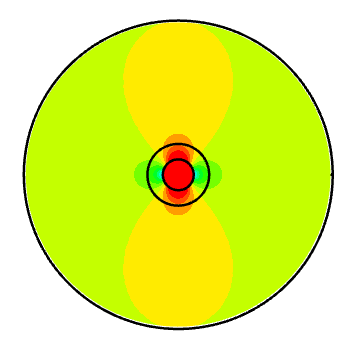

B imag [0, 1.4] 
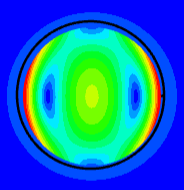

center field:((-4.3807329508598246e-06+2.693400514645348e-06j), (1.4346851038546058-0.9206111524557785j), (1.4596322281125558e-12-6.410395590135625e-13j))

Dirichlet=False feOrder=3

Jz real [-1e6, 1e6]
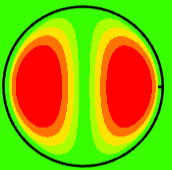

Jz imag [-5e6, 5e6] 
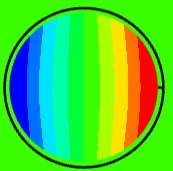

  Average Joule loss=  234.4377678845105

jomega=False feOrder=3 Dirichlet=False

B [0, 1.2]
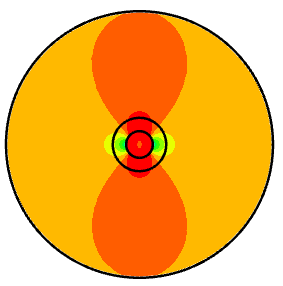

center field (3.3799644806074765e-06, 1.059219687983055, -1.004327548559388e-14)

Jz [-5e-6, 5e6]
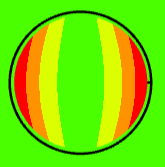

Average Joule loss=  331.0707943082912